In [1]:
# - megcsinálni, hogy éjjel is fusson amikor nem megy a notebook és utána ki tudjam elemezni az egészet

# - ezáltal több vm-n is tudom majd futtatni különböző beállításokkal


# - ha ez megvan akkor jöhet majd az hogy átteszem kerasba
#   - kérdés hogy gyorsabb lesz-e?
#   - meg tudom csinálni cnnre és ez a lényeg


# kedvenc tutorialom
# https://www.programiz.com/python-programming/package

In [2]:
# A megviálgosító felismerés

# Az, hogy bár az elején azt gondoltam, hogy simán mintázat felismeréssel meg lehet majd találni azokat a
# ki és belépési pontokat amelyek mentén sikeres kereskedést lehet csinálni - menet küözben lett egy új
# gondolatom.

#  Mi lenne ha a neurális hálónak menet közben mint bemenet visszatáplálnánk, hogy az adott trédben éppen
# mennyire sikeres.

#  Ennek az 1.1 verziója, hogy azt táplálom vissza neki, hogy mennyi idje van nyitva egy adott kereskedés.

#  Ez technikailag azért egy érdkese kihívás, mert az, hogy mennyi ideg van nyitva az nyilván a neurális
# háló kimenetétől és bemenetétől is függ.
# Ezért ez valamilyen for ciklus megoldással kéne, lehetne megvalósítani, tudom most elképzelni (de még
# nem teljesen pontsan) -> ezért ez végig gondolásra vár.

#  A másik megvalósítás amit úgy hívok hogy actor kritik háló vagyis egy másoidik neurális háló az eredeti
# signál fölött/után amely arról dönt egy második bemenet alapján, hogy figyelembe vegye-e a az eredeti
# signál következő vagy ellentétes irányú jelét vagy ne.
#  Tehát ez egy tök független második háló és csak az után kezd el dolgozni, hogy az első a teljes idősorra
# kiszámolta a kimenetet. A második háló bmenete viszont az, hogy van-e nyitva trade, hogy milyen irányú a
# trade és hogy mióta van nyitva, illetve, hogy éppen mekkora nyereség van rajta.
#  Ezek alapján pedig (1) minden időpillanatban el kell döntenie-hogy nyitja vagy zárja, vagy
# (2) csak azt kell eldöntenie, hogy a következő ellentétes irányú signálnál nyitva tartja-e vagy zájra.

In [3]:
# E fenti ötlet nagyon tetszik, de csak akkor kezdek el vele foglalkozni ha már meg van:

# - trend irányú indikátorok binárisra kódolva
# - keras implementáció (sebességmérés szempontjából)
# - éjszakai futtatásra alkalmas program
# - keras 1D/2D/3D CNN

In [4]:
# Egy teljesen másik dolog ami eszembe jutott,

#  Hogy lehetne több kimenete is annak a neurális hálónak aminek most egy kimenetet van és amely alapján a
# vétli és eladási poziciókat határozza meg a trader. Lehetne egy második, sőt harmadik kimenete is ami a
# stop értékét, vagy a pozició méretét határozza meg.

In [ ]:
# Egy másik probléma ami csak úgy eszembe jutott.

# Az egész rendszer rohadtul érzékeny a kiinduló neurális hálóra.

# Nos ahogy most csinálom az hogy véletlen szerűen inicializálok egyet és azt randomizálom meg egy nagyon
# picit az első körben (pont ugyan uyg és pont ugyan olyan mértékben mint ahogy az evolució során a később
# iekben is tenni fogom) Nos ez az ami lehet hogy baj, mert így tulajdonképpen a kiinduló populáció is
# elégé homogén azt kell hogy mondjam.

# Lehet, hogy sokkal jobb megoldás lenne, hogy ha ez első iteráicós lépésre inicializálnék több neurális
# hálót akár több ezret is és kiválasztanék belőle azt az egyet ami a legjobb és azt tenném be az evolúcióba

In [ ]:
# ------------------------------------------------------------------------------

!mkdir input
# !unzip archive.zip -d input
# !wget https://raw.githubusercontent.com/JoDeMiro/SACI22/main/Input/eurusd_minute_1000000.csv.gz     # <-- saját project
!wget https://raw.githubusercontent.com/JoDeMiro/SACI2022/main/Input/eurusd_minute_1000000.csv.gz     # <-- másik project
!mv eurusd_minute_1000000.csv.gz ./input/
!cd input
!gzip -f -d ./input/eurusd_minute_1000000.csv.gz
!rm ./input/eurusd_minute.csv
!mv ./input/eurusd_minute_1000000.csv ./input/eurusd_minute.csv

# ------------------------------------------------------------------------------

In [261]:
# ------------------------------------------------------------------------------

!mkdir temp

!wget https://github.com/JoDeMiro/SACI2022/raw/main/Input/eurusd_minute_close_only.zip

!mv eurusd_minute_close_only.zip ./temp/

!unzip -o ./temp/eurusd_minute_close_only.zip -d ./temp/

# ------------------------------------------------------------------------------

mkdir: cannot create directory ‘temp’: File exists
--2023-02-18 18:55:40--  https://github.com/JoDeMiro/SACI2022/raw/main/Input/eurusd_minute_close_only.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JoDeMiro/SACI2022/main/Input/eurusd_minute_close_only.zip [following]
--2023-02-18 18:55:40--  https://raw.githubusercontent.com/JoDeMiro/SACI2022/main/Input/eurusd_minute_close_only.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14528963 (14M) [application/zip]
Saving to: ‘eurusd_minute_close_only.zip’

eurusd_minute_close 100%[===================>]  13.86M  --.-KB/s    in 0.09s   

2023-

In [262]:
import os
import sys
import glob
import keras
import pprint
import sklearn
import ipywidgets
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor

from keras.models import Sequential
from keras.layers import Dense, Activation

from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Checkbox
from IPython.display import display

from matplotlib.ticker import StrMethodFormatter
from matplotlib import cm

import time
import talib
import random
import joblib
from sys import maxsize
from datetime import datetime

import importlib

print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('Keras version:{}'.format(keras.__version__))
print('Tensorflow version:{}'.format(tf.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__)) 

Python version:3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
Numpy version:1.23.5
Pandas version:1.3.5
Keras version:2.10.0
Tensorflow version:2.10.0
Sci-Kit Learn version:1.0.2


In [279]:
import modules.datareader
from modules.datareader import DataReader

import modules.experiment
from modules.experiment import Experiment

import modules.nn
from modules.nn import NN, KerasMLP

import modules.trader
from modules.trader import Trader

import modules.randomer
from modules.randomer import Randomer

import modules.plotter
from modules.plotter import Plotter


import modules.fuk
from modules.fuk import plot_trade_adv
from modules.fuk import create_animated_mp4
from modules.fuk import save_model_trader_results
from modules.fuk import run_info

def reload():
    importlib.reload(modules.datareader)
    importlib.reload(modules.nn)
    importlib.reload(modules.fuk)
    importlib.reload(modules.trader)
    importlib.reload(modules.plotter)
    importlib.reload(modules.experiment)

reload()

In [280]:
reload()

There are 1840000 rows and 1 columns
   1.355499999999999927e+00
0                    1.3555
1                    1.3562
2                    1.3560
3                    1.3563
4                    1.3562
------------------------------------------------------------------------------
(1840000, 2)
(1840000, 1)
(1840000, 1)
------------------------------------------------------------------------------
(1840000, 1)
(1840000,)
(1840000, 1)
indcator section
------------------------------------------------------------------------------
Set window = 10
------------------------------------------------------------------------------
The train dataset 1839990, and the labels 1839990
(1839990, 10, 15) (1839990, 1)
x_train.nbytes =  2207988.0 Kbyte
x_train.nbytes =  2207.988 Mbyte
------------------------------------------------------------------------------
0
1840000
create test set section


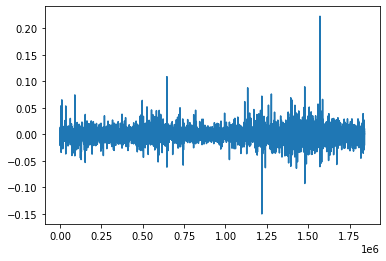

In [266]:
ROW = 1840000
FROM = 0
DIFF_MULTIPLIER = 10
INPUT_MULTIPLIER = 10

WINDOW = 10

INDICATORS = ['ROC1', 'ROC2', 'ROC3', 'RSI14', 'RSI28',
              'MACD',
              'MA50BIN', 'MA50DIS', 'MA100BIN', 'MA100DIS', 'LIN30', 'LIN50']

data_reader = DataReader(nRowsRead=ROW)
# data_reader.load_with_pandas(path = './input/eurusd_minute.csv')

data_reader.load_with_pandas(path = './temp/56.csv')
data_reader.df = data_reader.df.rename({data_reader.df.columns[0]: 'BC'}, axis=1)
data_reader.df['Date'] = np.arange(0, data_reader.df['BC'].size, 1) # az elötte lévő sorral együtt kel (!)

data_reader.cut(FROM, ROW)
#data_reader.info()
# data_reader.df.info()
data_reader.set_target()
# data_reader.show_array_info()
data_reader.create_diff(DIFF_MULTIPLIER)
data_reader.remove_price()
data_reader.input = data_reader.input * INPUT_MULTIPLIER
data_reader.create_indicators(extended=True, indicators=INDICATORS)
data_reader.set_window(WINDOW)
# data_reader.normalize_values()       # experiment
data_reader.create_train_set()
data_reader.create_test_set()


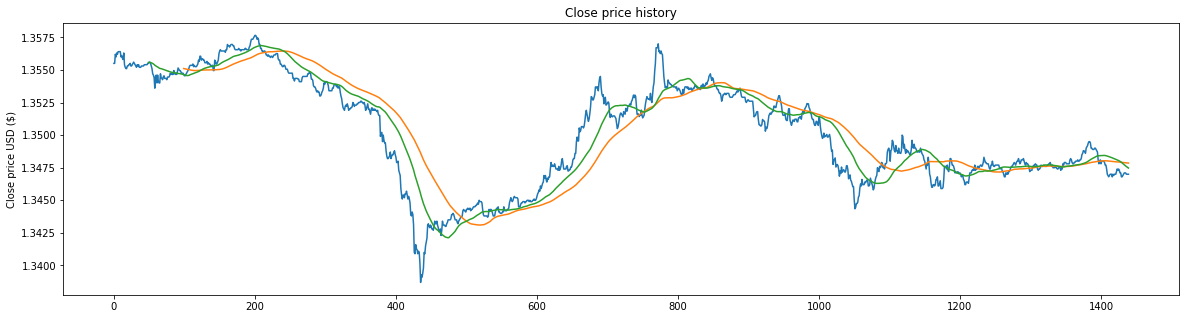

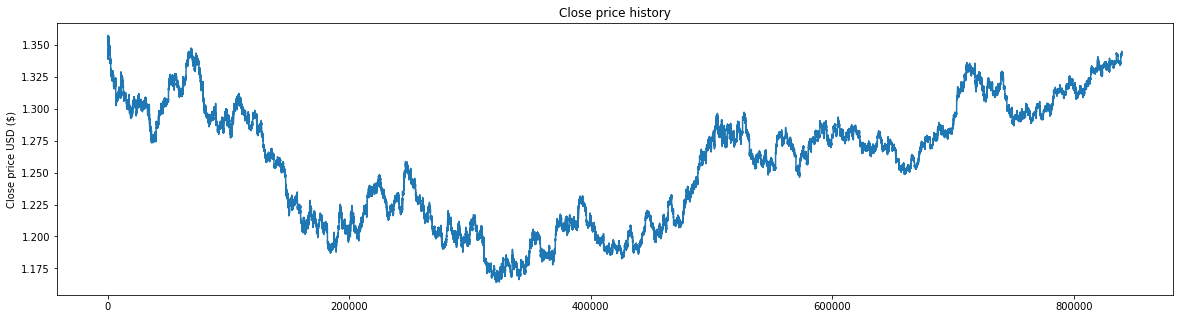

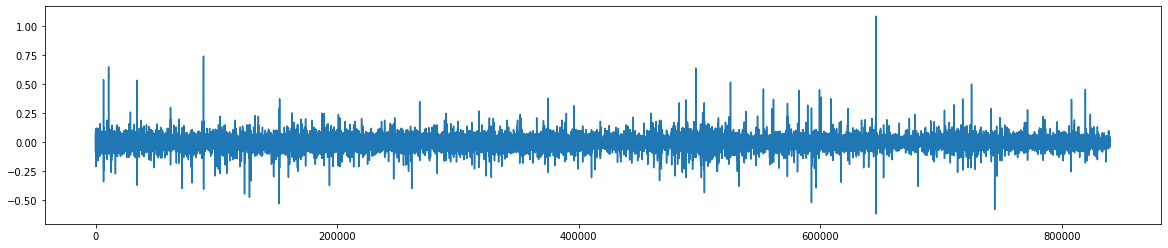

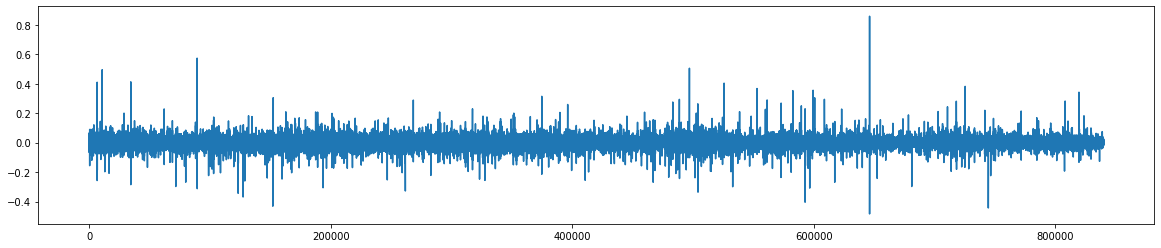

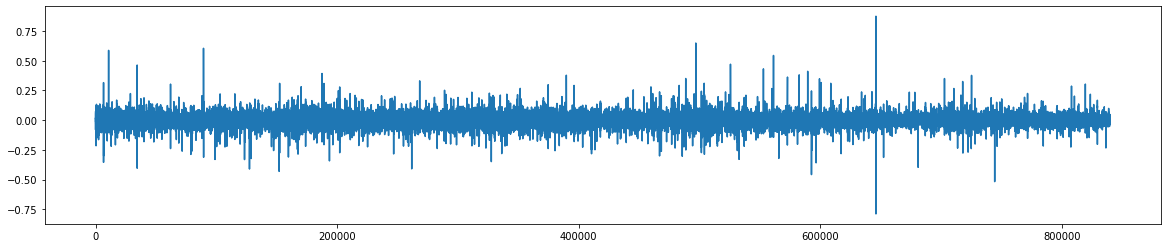

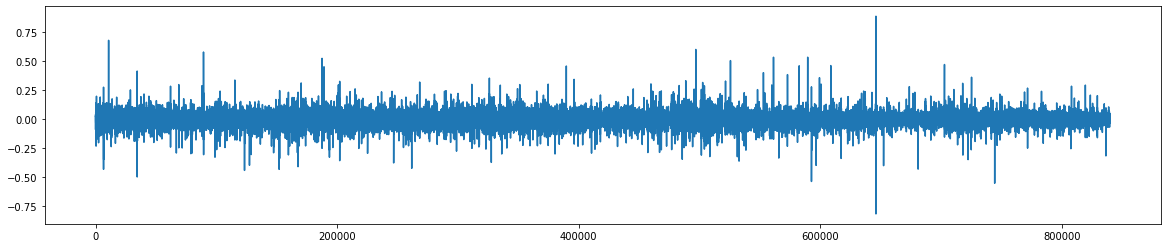

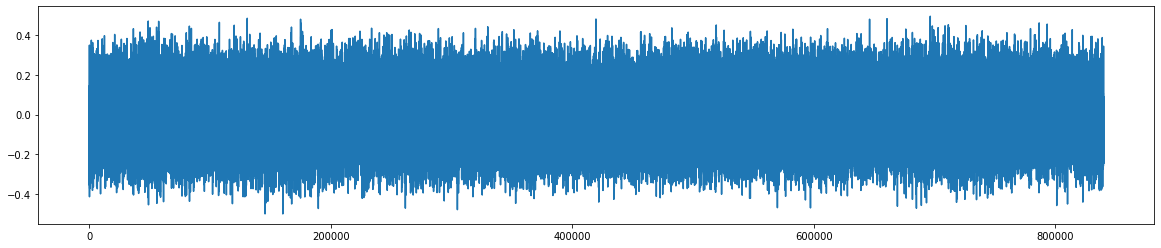

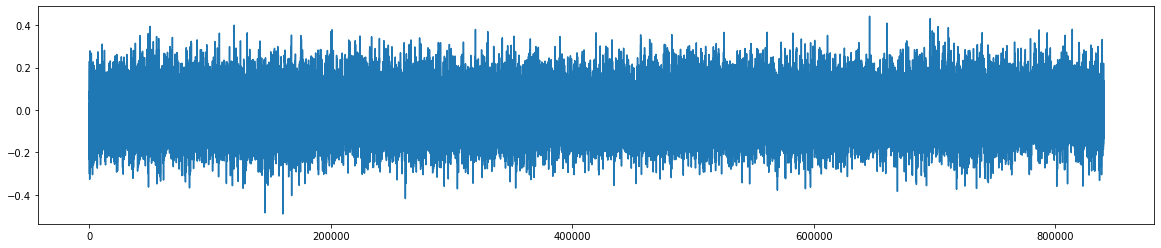

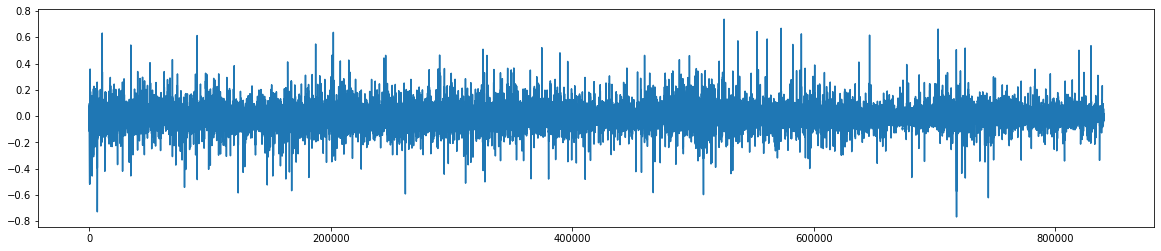

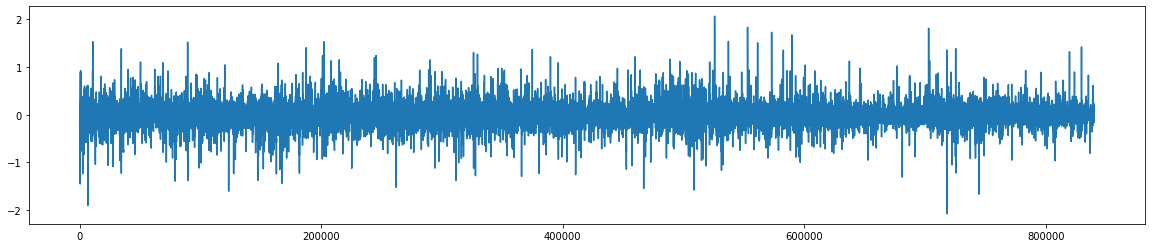

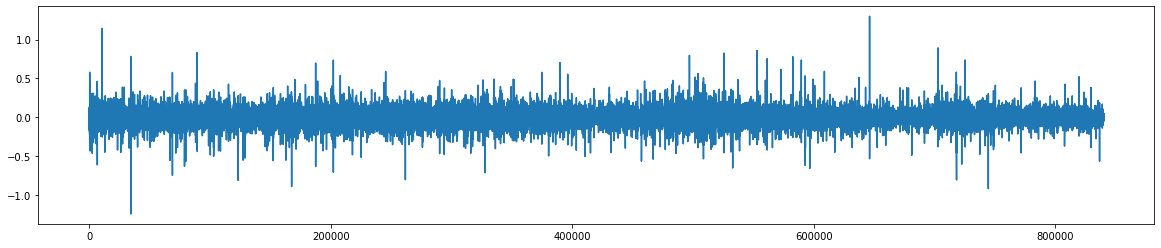

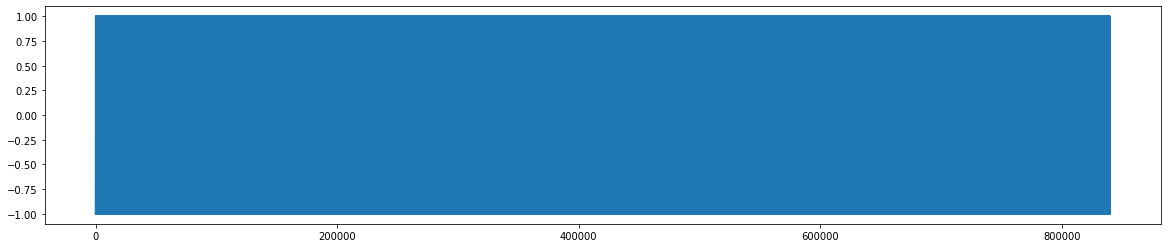

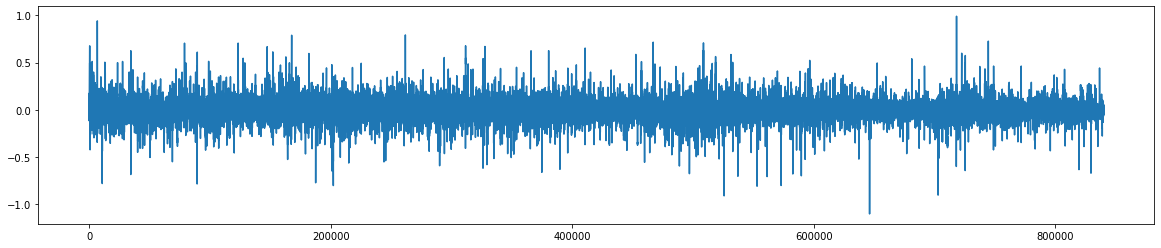

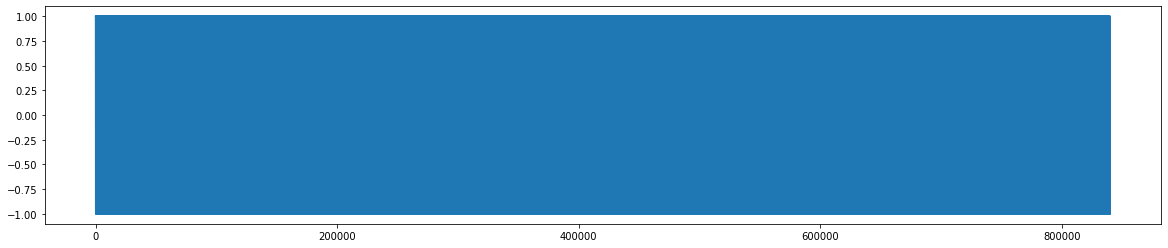

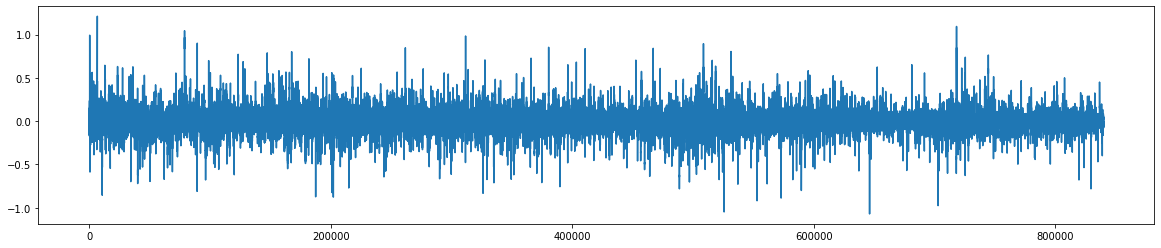

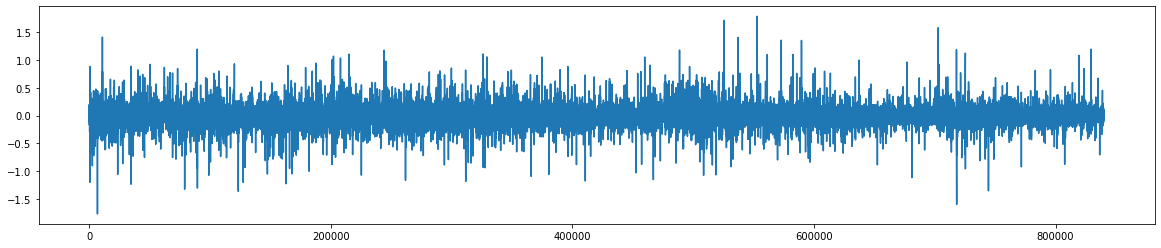

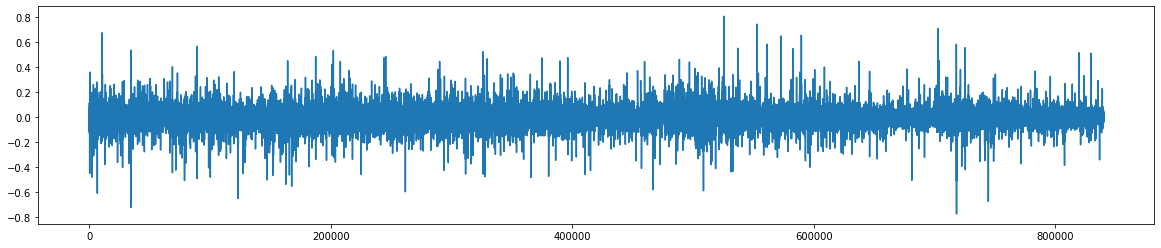

In [176]:
_100 = talib.MA(data_reader.array[:, 0], timeperiod=100)
_50  = talib.MA(data_reader.array[:, 0], timeperiod=50)

_ig = 1440

plt.figure(figsize=(20,5))
plt.title('Close price history')
plt.plot(data_reader.array[:_ig])
plt.plot(_100[:_ig])
plt.plot(_50[:_ig])
plt.ylabel('Close price USD ($)')
plt.show()

plt.figure(figsize=(20,5))
plt.title('Close price history')
plt.plot(data_reader.array)
plt.ylabel('Close price USD ($)')
plt.show()

for i in range(data_reader.input.shape[-1]):
    plt.figure(figsize=(20, 4))
    plt.plot(data_reader.input[:, i])

    1440 perc egy nap -> 14400 perc -> 10 nap 28800 -> 20 nap
    
    szóval 28K az még mindíg csak 20 nap az nem olyan sok, de még ezen sem tudom ránevelni, hogy rásimuljon

In [185]:

FIRST = 10
SECOND = 5

# ------------------------------------------------------------------------------

# Scikit
nn = NN(x_train = data_reader.x_train, y_train = data_reader.y_train)
nn.init_nn(_first = FIRST, _second = SECOND, activation='tanh')

# nn.mlp.coefs_                                                                     # <-- ha debuggolni kell

# ------------------------------------------------------------------------------

# Keras
kn = KerasMLP(x_train = data_reader.x_train, y_train = data_reader.y_train)
kn.init_nn(_first = FIRST, _second = SECOND, activation='tanh')

# kn.mlp.get_weights()                                                              # <-- ha debuggolni kell

# ------------------------------------------------------------------------------

_ = nn.knn_to_snn(kn)



In [199]:
TRADE_COST = 0.0005                  # jelenleg a minimális költég 5x adtam az igazinak -> erős
TRADE_COST = 0.000160
MINIMALMOV = 0.000010
MINTPROFIT = 0.000160
DYNASPREAD = 0.000080                # a spread a minimal movenak a 8x
THRESHOLD = 0.0
TH = 1.065

trader = Trader(threshold=THRESHOLD,
                data_reader=data_reader,
                trade_cost=TRADE_COST,
                th=TH)


pred = nn.create_prediction()
result = trader.calculator_np(pred)

# plot_trade_adv(trader, window=trader.window)
# plot_trade_adv(trader, trader_signal=pred, window=trader.window)

print(result)
# trader.result



__init__ Trader
{'buy_count': 2228, 'sell_count': 2228, 'gain': -0.3060100000000029}


In [200]:
_ = data_reader.y_train.size // 1440
print('nap =', _)
print('trade/nap =', result['buy_count'] / _)

nap = 583
trade/nap = 3.8216123499142367


In [201]:
# nn.mlp.activation = 'tanh'
# nn.mlp.hidden_layer_sizes = (4)

nn.mlp.get_params()

{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 9900000,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (10, 5),
 'learning_rate': 'constant',
 'learning_rate_init': 1e-10,
 'max_fun': 15000,
 'max_iter': 1,
 'momentum': 0.9,
 'n_iter_no_change': 99999999,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': False,
 'solver': 'sgd',
 'tol': 0.0001,
 'validation_fraction': 0.0,
 'verbose': False,
 'warm_start': False}

In [202]:
ex = Experiment(data_reader, nn)

In [203]:

conf = dict()
conf['TRADE_COST'] = 0.000160 # 0.0005
conf['THRESHOLD']  = 0.0
conf['TH']         = 1.065

conf['internal_plotting'] = True
conf['repeatable']        = False
conf['re_learn']          = False

conf['generation']        = 100
conf['population']        = 20
conf['factor_weight']     = 100
conf['factor_intercept']  = 200
conf['variable_factor']   = True
conf['factor_min']        = 20         # 0.1   _minnél kisebb annál radikálisabban változtat a súlyon (átirn)
conf['factor_max']        = 200         # 15    _minnél nagyobb annál kevésbé változtat a súlyon
conf['keep_best']         = True
conf['select_ratio_weight']   = 1
conf['select_ratio_bias']     = 1
conf['variable_select_ratio'] = True
conf['select_ratio_min']      = 0.1     # 0.1
conf['select_ratio_max']      = 0.2     # 0.9

ex.exp(conf)

create_animated_mp4('price*.png', framerate=1, quite=True)


__init__ Trader
0
new best_solution find individual =  0
i = 0 j = 0 	score =  -0.3060100000000029
new best_solution find individual =  2
i = 0 j = 2 	score =  -0.26704000000000216
best_score in generation i =  0  =  -0.26704000000000216
(array([   1,    4,    7,    8,    9,   10,   11,   12,   13,   14,   15,
         16,   18,   19,   20,   21,   22,   24,   25,   26,   27,   28,
         29,   30,   31,   32,   33,   34,   35,   36,   37,   38,   39,
         40,   41,   42,   43,   44,   45,   46,   47,   48,   49,   50,
         51,   52,   53,   54,   55,   56,   57,   58,   59,   60,   61,
         62,   63,   64,   65,   66,   67,   68,   69,   70,   71,   72,
         73,   74,   75,   76,   77,   78,   79,   80,   81,   82,   83,
         84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,
         95,   96,   97,   98,   99,  100,  101,  102,  103,  104,  105,
        106,  107,  108,  109,  110,  111,  112,  113,  114,  115,  116,
        117,  118,  119,  120, 

new best_solution find individual =  16
i = 16 j = 16 	score =  -0.03476000000000056
best_score in generation i =  16  =  -0.03476000000000056
new best_solution find individual =  4
i = 17 j = 4 	score =  0.0038599999999958945
best_score in generation i =  17  =  0.0038599999999958945
new best_solution find individual =  2
i = 18 j = 2 	score =  0.051989999999995734
new best_solution find individual =  9
i = 18 j = 9 	score =  0.05780999999999561
best_score in generation i =  18  =  0.05780999999999561
new best_solution find individual =  7
i = 25 j = 7 	score =  0.06463999999999592
new best_solution find individual =  14
i = 25 j = 14 	score =  0.06824999999999633
best_score in generation i =  25  =  0.06824999999999633
new best_solution find individual =  2
i = 27 j = 2 	score =  0.07363999999999608
best_score in generation i =  27  =  0.07363999999999608
new best_solution find individual =  5
i = 28 j = 5 	score =  0.08070999999999587
best_score in generation i =  28  =  0.080709999

In [204]:
# rekorder 0.040

<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>
<class 'modules.trader.Trader'>
<class 'list'>
1069.7832 sec 	 total time
469.5949 sec 	 mlp pred
0.4905 sec 	 randomer
599.6410 sec 	 trader


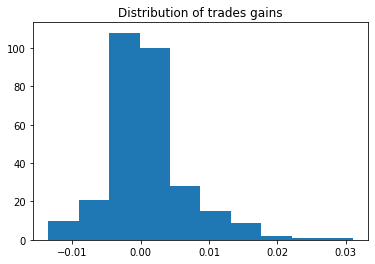

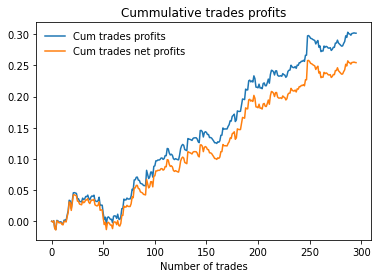

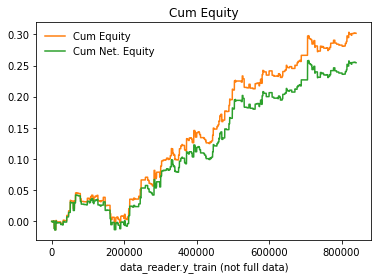

In [205]:
trader = ex.trader
trader.result

# save model
save_model_trader_results(ex)

# shor ex runtime info
run_info(ex)

# create plotter
plotter = Plotter(trader.result)

# plot result
plotter.plot_res(trader)


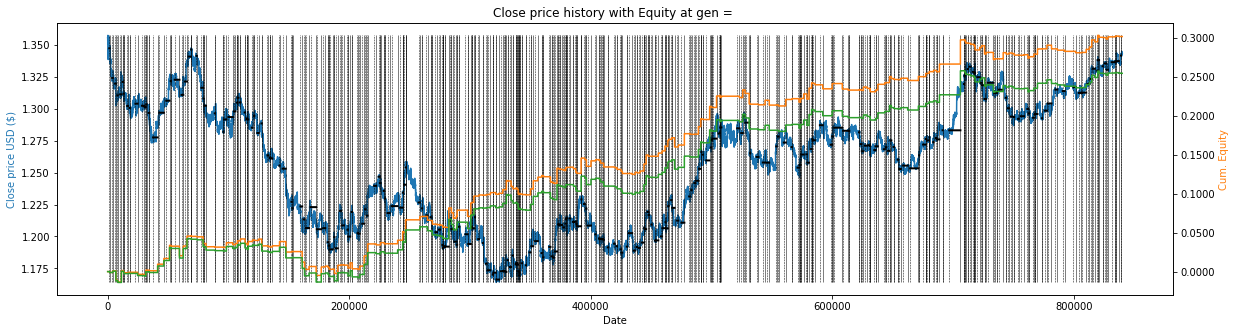

In [207]:

plot_trade_adv(trader, _from=0, _back=0, window=trader.window, step=True)


In [208]:
_from   = IntSlider(min=0, max=12000, step=1, value=0, description='start')
_back   = IntSlider(min=0, max=12000, step=1, value=0, description='back')
_window = IntSlider(min=-10, max=trader.window, step=1, value=trader.window, description='window')
_step   = Checkbox(value=True, description='step')
_trd    = fixed(trader)

ui = ipywidgets.HBox([_from, _back, _window, _step])
params = {'trader': _trd, '_from': _from, '_back': _back, 'window': _window, 'step': _step}
out = ipywidgets.interactive_output(plot_trade_adv, params)
display(ui, out)

Output()

[[  1324]
 [  3770]
 [  6139]
 [  6669]
 [  8091]
 [ 10295]
 [ 10863]
 [ 12447]
 [ 13274]
 [ 16192]
 [ 18311]
 [ 18313]
 [ 22966]
 [ 23874]
 [ 24486]
 [ 24609]
 [ 28383]
 [ 29912]
 [ 30541]
 [ 32072]
 [ 33944]
 [ 34470]
 [ 37571]
 [ 38897]
 [ 39748]
 [ 41066]
 [ 42732]
 [ 45252]
 [ 48499]
 [ 51181]
 [ 52150]
 [ 55481]
 [ 59040]
 [ 61193]
 [ 64072]
 [ 66894]
 [ 68814]
 [ 69143]
 [ 73526]
 [ 77590]
 [ 78778]
 [ 79287]
 [ 80032]
 [ 88643]
 [ 88681]
 [ 95778]
 [ 96480]
 [ 96566]
 [ 97088]
 [ 99950]
 [101364]
 [104489]
 [104519]
 [104682]
 [105432]
 [107118]
 [107287]
 [107293]
 [107471]
 [109511]
 [113403]
 [115079]
 [115462]
 [116210]
 [116344]
 [119356]
 [121147]
 [123948]
 [124228]
 [127367]
 [127369]
 [132322]
 [134486]
 [134703]
 [142123]
 [144818]
 [152141]
 [152857]
 [159597]
 [162168]
 [164243]
 [164430]
 [165351]
 [165376]
 [168032]
 [169233]
 [173162]
 [174694]
 [175581]
 [178475]
 [182118]
 [182321]
 [182956]
 [183771]
 [187602]
 [187604]
 [188993]
 [192389]
 [194112]
 [194800]


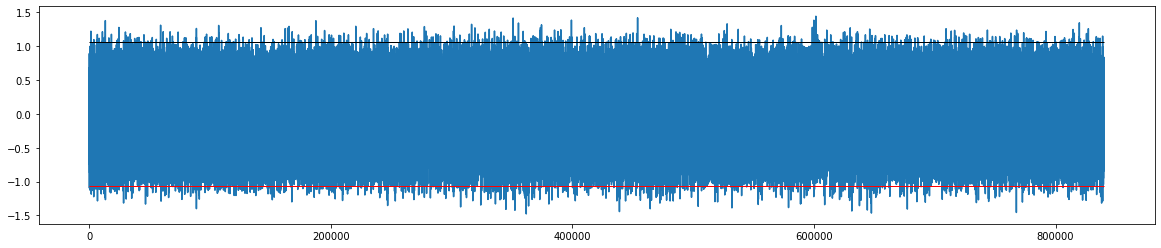

In [209]:
# ToDo: ezt bebaszni a plotter osztályba (signál és a thresholdok)

plt.figure(figsize=(20, 4))
plt.plot(ex.test_pred)
_x_max = ex.test_pred.shape[0]
plt.hlines(trader.th_dn, 0, _x_max, lw=1.0, color='red')
plt.hlines(trader.th_up, 0, _x_max, lw=1.0, color='black')
print(np.argwhere(ex.test_pred > ex.trader.th_up))
plt.show()

In [210]:
start = IntSlider(min=0, max=12000, step=1, value=0, description='start')
end   = IntSlider(min=-14000, max=-1, step=1, value=1, description='end')

p     = Checkbox(description='predicted', value=True)
i     = Checkbox(description='initial', value=True)

e     = fixed(ex)

params = {'ex': e, 'start': start, 'end': end, 'p': p, 'i': i}

ui = ipywidgets.HBox([start, end, p, i])
out = ipywidgets.interactive_output(plotter.plot_int, params)
display(ui, out)


Output()

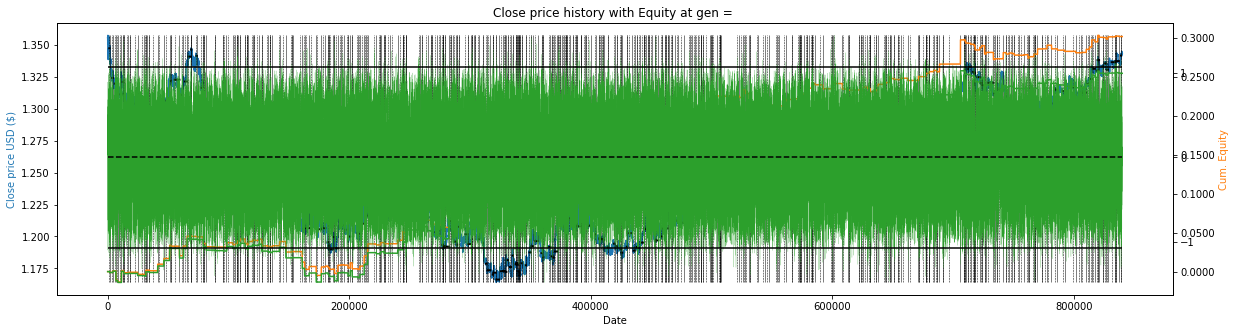

In [211]:
plot_trade_adv(trader, trader_signal=ex.test_pred, window=trader.window, _from=0, _back=0)

## Visualise net - Best Solution

[150  10   5   1]


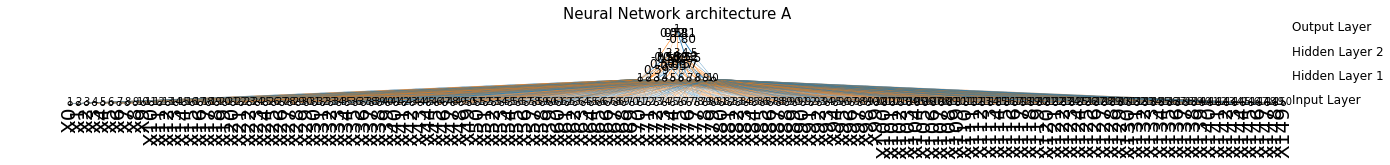

In [212]:
plotter.vshow(ex.result['best_generation_solution'])

## Visualise net - Initial ('Empty') Solution

[150  10   5   1]


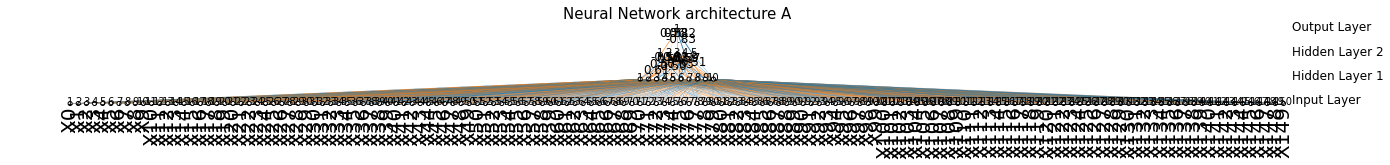

In [213]:
plotter.vshow(ex.attach['backup_mlp'])


```
# JoDeMiro
```


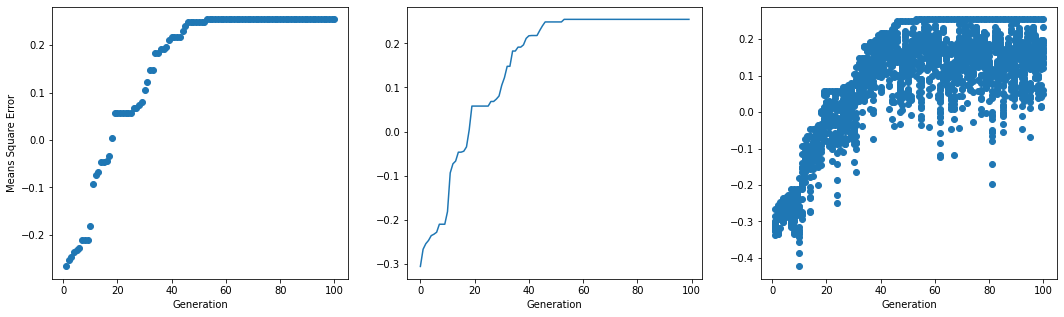

In [214]:
plotter = Plotter(ex.result)

plotter.plot_results(2000, True)

In [215]:
_max = IntSlider(min=40, max=800, step=1, value=120)

interact(plotter.plot_results, _max=_max, _show_mid=True, _show_avg=True);

interactive(children=(IntSlider(value=120, description='_max', max=800, min=40), Checkbox(value=True, descript…

In [216]:

# meg van minden -> nézzük meg milyen lépéseket kell tennem ahoz, hogy a test adatokon is lefusson


## Test the model on extended data

Experimental

Sajnos a normalizáció miatt el fog csúszni, ezért az lenne az igazi, hogy ha a normalizációt nem csinálnám meg rajta.

There are 2935000 rows and 1 columns
   1.355499999999999927e+00
0                    1.3555
1                    1.3562
2                    1.3560
3                    1.3563
4                    1.3562
------------------------------------------------------------------------------
(2935000, 2)
(2935000, 1)
(2935000, 1)
------------------------------------------------------------------------------
(2935000, 1)
(2935000,)
(2935000, 1)
indcator section
------------------------------------------------------------------------------
Set window = 10
------------------------------------------------------------------------------
The train dataset 2934990, and the labels 2934990
(2934990, 10, 15) (2934990, 1)
x_train.nbytes =  3521988.0 Kbyte
x_train.nbytes =  3521.988 Mbyte
------------------------------------------------------------------------------


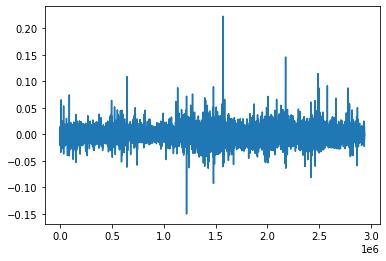

In [302]:

test_data_reader = DataReader(nRowsRead=2935000)                                 # <-- instantiate DataReader (set number of rows for data)

# test_data_reader.load_with_pandas(path = './input/eurusd_minute.csv')           # <-- read a particular files from disk (return with df, but also set self)


test_data_reader.load_with_pandas(path = './temp/56.csv')
test_data_reader.df = test_data_reader.df.rename({test_data_reader.df.columns[0]: 'BC'}, axis=1)
test_data_reader.df['Date'] = np.arange(0, test_data_reader.df['BC'].size, 1) # az elötte lévő sorral együtt kel (!)


test_data_reader.cut(0, 2940000)                                                 # <-- cut from to (start, to)

# test_data_reader.info()                                                       # <-- my own info() function

# test_data_reader.df.info()                                                    # <-- call pandas built-in info() function

test_data_reader.set_target()                                                   # <-- prepare is setter convert pandas to numpy and set target variable

# test_data_reader.show_array_info()

test_data_reader.create_diff(DIFF_MULTIPLIER)        # innentől self.input

test_data_reader.remove_price()

test_data_reader.input = test_data_reader.input * INPUT_MULTIPLIER

test_data_reader.create_indicators(extended=True, indicators=INDICATORS)

# test_data_reader.normalize_values()                                           # <-- transform data between range (-1,1)

test_data_reader.set_window(ex.data_reader.window)                                                      # <-- set window size

test_data_reader.create_train_set()                                             # <-- prepare egyik legfontossab metódusa (sok transzformációval)


In [303]:
conf

{'TRADE_COST': 0.00016,
 'THRESHOLD': 0.0,
 'TH': 1.065,
 'internal_plotting': True,
 'repeatable': False,
 're_learn': False,
 'generation': 100,
 'population': 20,
 'factor_weight': 100,
 'factor_intercept': 200,
 'variable_factor': True,
 'factor_min': 20,
 'factor_max': 200,
 'keep_best': True,
 'select_ratio_weight': 1,
 'select_ratio_bias': 1,
 'variable_select_ratio': True,
 'select_ratio_min': 0.1,
 'select_ratio_max': 0.2}

In [304]:

TRADE_COST = conf['TRADE_COST']
THRESHOLD  = conf['THRESHOLD']
TH = conf['TH']

print('TH        ', TH)
print('TRADE_COST', TRADE_COST)

trader = Trader(threshold=THRESHOLD,
                data_reader=test_data_reader,
                trade_cost=TRADE_COST,
                th=TH,
                debug=False)

TH         1.065
TRADE_COST 0.00016
__init__ Trader


In [305]:
# 0.24932000000000176

In [306]:
# A globalisan legjobb megoldás alapján csináljuk meg a becslést
test_pred = ex.result['best_generation_solution'].predict(
    test_data_reader.x_train)  # <-- kiértékeléshez és vizualizációhoz

# Végül minden esetben updateljük a trader.result-ot azáltal, hogy meghívjuk a következőt
replayed_result = trader.calculator_np(test_pred)

replayed_result

{'buy_count': 1236, 'sell_count': 1236, 'gain': 0.007350000000003409}

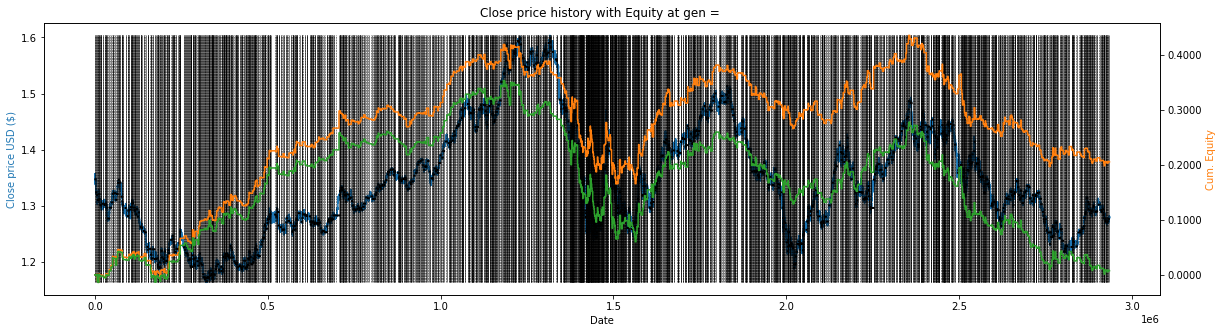

In [307]:

plot_trade_adv(trader, _from=0, _back=0, window=trader.window, step=True)


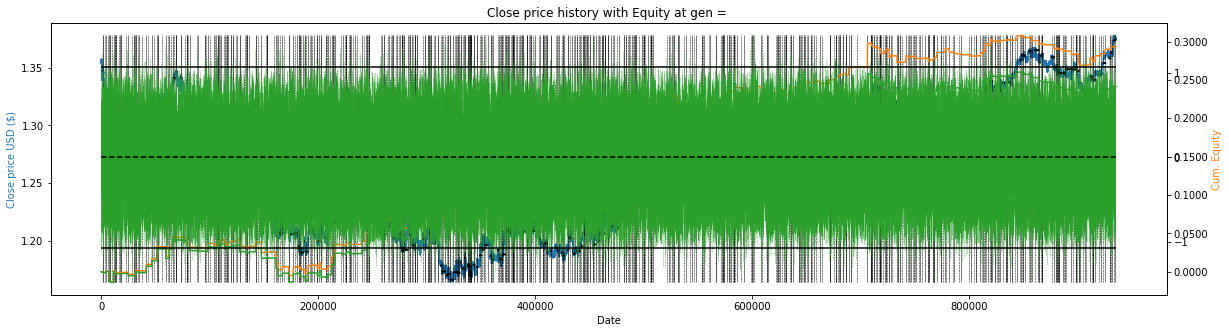

In [222]:

plot_trade_adv(trader, trader_signal=test_pred, window=trader.window, _from=0, _back=0)


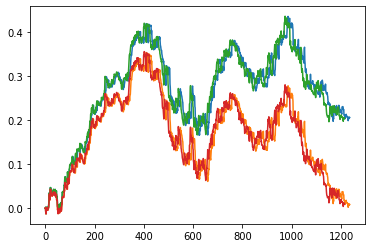

In [308]:
# nincs rajta a kötési költség azért tündököl ilyen szépen

trader.result.keys()
_raw_eq = np.cumsum(trader.result['sell_price']-trader.result['buy_price'])
plt.plot(_raw_eq)

_net_eq = np.cumsum(trader.result['sell_price']-trader.result['buy_price']-trader.trade_cost)
plt.plot(_net_eq)

#leveszem a nagyon rövid tradeket
_min = 30
_raw_eq_min = np.cumsum(trader.result['sell_price'][trader.result['trade_length'] > _min] - 
              trader.result['buy_price'][trader.result['trade_length'] > _min])
plt.plot(_raw_eq_min)

_net_eq_min = np.cumsum(trader.result['sell_price'][trader.result['trade_length'] > _min] - 
              trader.result['buy_price'][trader.result['trade_length'] > _min] - trader.trade_cost)
plt.plot(_net_eq_min)
# sajnos a rövid tradek adnak sok profitot

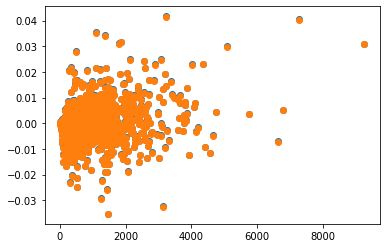

In [309]:
# profit tradenként és tradek hossz aközötti öszfüg

t_raw_prof = trader.result['sell_price'] - trader.result['buy_price']
t_net_prof = trader.result['sell_price'] - trader.result['buy_price'] - trader.trade_cost
tlen  = trader.result['trade_length']
plt.scatter(tlen, t_raw_prof)
plt.scatter(tlen, t_net_prof)

(array([  3.,   6.,  35., 203., 698., 209.,  56.,  17.,   5.,   4.]),
 array([-0.03532 , -0.027632, -0.019944, -0.012256, -0.004568,  0.00312 ,
         0.010808,  0.018496,  0.026184,  0.033872,  0.04156 ]),
 <BarContainer object of 10 artists>)

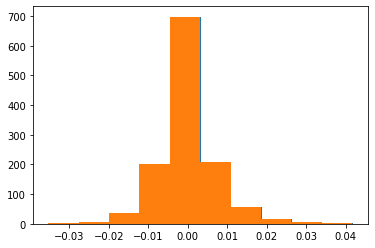

In [310]:
# jó lenne látni a profit eloszlását is

plt.hist(t_raw_prof)
plt.hist(t_net_prof)

(array([[  0.,   4.,  18., 132., 549.,  93.,  13.,   4.,   1.,   0.],
        [  2.,   2.,   9.,  43., 104.,  70.,  24.,   4.,   1.,   2.],
        [  0.,   0.,   6.,  20.,  31.,  30.,  13.,   4.,   1.,   0.],
        [  1.,   0.,   1.,   4.,   7.,   8.,   5.,   3.,   0.,   1.],
        [  0.,   0.,   1.,   2.,   7.,   5.,   1.,   2.,   0.,   0.],
        [  0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.]]),
 array([1.0000e+00, 9.2810e+02, 1.8552e+03, 2.7823e+03, 3.7094e+03,
        4.6365e+03, 5.5636e+03, 6.4907e+03, 7.4178e+03, 8.3449e+03,
        9.2720e+03]),
 array([-0.03516 , -0.027472, -0.019784, -0.012096, -0.004408,  0.00328 ,
         0.010968,  0.018656,  0.026344,  0.034032,  0.04172 ]),
 

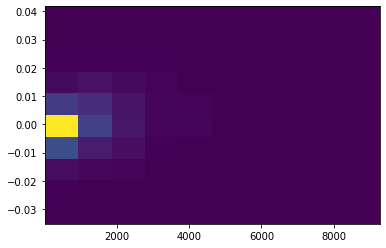

In [311]:
plt.hist2d(tlen, t_raw_prof)

In [312]:
_avg_trade_lenght = trader.result['trade_length'].mean()
print(f'átlagos trade hossz = {_avg_trade_lenght:0.2f}')

átlagos trade hossz = 893.20


átlagos trade hossz 893.1990291262136
átlagos trade hossz 714.7556131260794


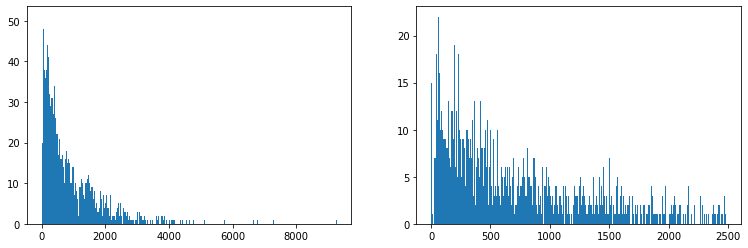

In [313]:
fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4))
_ = ax[0].hist(trader.result['trade_length'], bins=320)
_ = trader.result['trade_length']
print('átlagos trade hossz', _.mean())

_ = trader.result['trade_length']
_ = _[_ < 2500]
print('átlagos trade hossz', _.mean())
_ = ax[1].hist(_, bins=320)
plt.show()

In [314]:
print(f'avg =  {t_raw_prof.mean():.10f}')
print(f'max =  {t_raw_prof.max():.10f}')
print(f'min = {t_raw_prof.min():.10f}')

avg =  0.0001659466
max =  0.0417200000
min = -0.0351600000


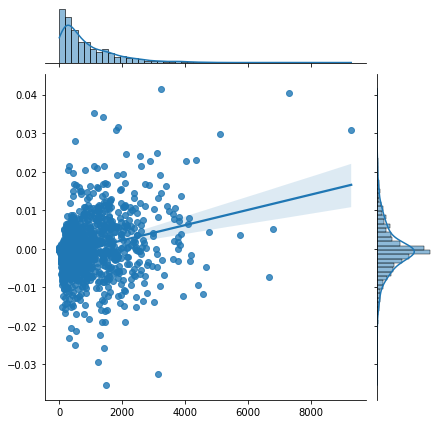

In [315]:
import seaborn as sns

sns.jointplot(x=tlen, 
              y=t_net_prof,
              kind='reg');

# plt.title("Scatter Plot with Marginal Histograms: Seaborn", size=18, pad=80)



```
# JoDeMiro
```
